# CONVOLUTIONAL NEURAL NETWORK TUTORIAL

*by Ignacio Carracedo and Nan Wang*

This tutorial is based and extracts most of the information from the following Kaggle kernel:

https://www.kaggle.com/kakauandme/tensorflow-deep-nn

----------------------------

    1. Introduction
        1.1 An introduction to convolutional neural networks (CNN)
    2. Data preparation
    3. Tensor Flow graph
    4. Training and validation
    5. Predict
    6. Visualize hidden layers

---------------------------------------------------------------------------

## 1. Introduction

The goal of this notebook is to build a convolutional neural network to classify the MNIST data set. We also want to vizualize the activation maps of the hidden layers to see what features are being created from the images.

### 1.1 An introduction to convolutional neural networks (CNN)

*Concepts taken mostly from: https://devblogs.nvidia.com/parallelforall/deep-learning-nutshell-core-concepts/*


#### CONVOLUTION

There are several interpretations of convolution and while it is unknown which interpretation of convolution is correct for deep learning, the cross-correlation interpretation is currently the most useful: convolutional filters can be interpreted as feature detectors, that is, the input (feature map) is filtered for a certain feature (the kernel) and the output is large if the feature is detected in the image. This is exactly how you interpret cross-correlation for an image.

#### STRIDE AND PADDING

There are 2 main parameters that we can change to modify the behavior of each layer (CONVOLUTION). After we choose the filter size, we also have to choose the stride and the padding.

Stride controls how the filter convolves around the input volume. In the example we had in part 1, the filter convolves around the input volume by shifting one unit at a time. The amount by which the filter shifts is the stride.

Zero padding pads the input volume with zeros around the border

If you have a stride of 1 and if you set the size of zero padding to (K-1)/2 where K is the filter size, then the input and output volume will always have the same spatial dimensions.

#### POOLING / SUBSAMPLING

Pooling is a procedure that takes input over a certain area and reduces that to a single value (subsampling). In convolutional neural networks, this concentration of information has the useful property that outgoing connections usually receive similar information (the information is “funneled” into the right place for the input feature map of the next convolutional layer). This provides basic invariance to rotations and translations. For example, if the face on an image patch is not in the center of the image but slightly translated, it should still work fine because the information is funneled into the right place by the pooling operation so that the convolutional filters can detect the face.
The larger the size of the pooling area, the more information is condensed, which leads to slim networks that fit more easily into GPU memory. However, if the pooling area is too large, too much information is thrown away and predictive performance decreases.

#### FULLY CONNECTED LAYER

This layer basically takes an input volume (whatever the output is of the conv or ReLU or pool layer preceding it) and outputs an N dimensional vector where N is the number of classes that the program has to choose from. The way this fully connected layer works is that it looks at the output of the previous layer (which as we remember should represent the activation maps of high level features) and determines which features most correlate to a particular class. Basically, a FC layer looks at what high level features most strongly correlate to a particular class and has particular weights so that when you compute the products between the weights and the previous layer, you get the correct probabilities for the different classes.

#### DROPOUT LAYERS

Now, dropout layers have a very specific function in neural networks. In the last section, we discussed the problem of overfitting, where after training, the weights of the network are so tuned to the training examples they are given that the network doesn’t perform well when given new examples. The idea of dropout is simplistic in nature. This layer “drops out” a random set of activations in that layer by setting them to zero in the forward pass. Simple as that. Now, what are the benefits of such a simple and seemingly unnecessary and counterintuitive process? Well, in a way, it forces the network to be redundant. By that I mean the network should be able to provide the right classification or output for a specific example even if some of the activations are dropped out. It makes sure that the network isn’t getting too “fitted” to the training data and thus helps alleviate the overfitting problem. An important note is that this layer is only used during training, and not during test time.

#### CONVOLUTIONAL NEURAL NETWORK (CNN)

A convolutional neural network, or preferably convolutional network or convolutional net uses convolutional layers that filter inputs for useful information.  These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand (see Feature Learning). For example, in a general object recognition task it might be most useful to filter information about the shape of an object (objects usually have very different shapes) while for a bird recognition task it might be more suitable to extract information about the color of the bird (most birds have a similar shape, but different colors; here color is more useful to distinguish between birds). Convolutional networks adjust automatically to find the best feature for these tasks. Usually, multiple convolutional layers are used that filter images for more and more abstract information after each layer (see hierarchical features).

Convolutional networks usually also use pooling layers (see pooling) for limited translation and rotation invariance (detect the object even if it appears at some unusual place). Pooling also reduces the memory consumption and thus allows for the usage of more convolutional layers.     

First, we import all libraries requiered to run this notebook.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

## 2. Data preparation

First, we define the settings of our neural network and other options:

In [2]:
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 1600   

DROPOUT = 0.5
BATCH_SIZE = 25

VALIDATION_SIZE = 2000

Then, we load training data and check size and column names:

In [3]:
data = pd.read_csv('./data/train.csv')

In [4]:
print("the size of the training data is {}".format(data.shape))
print("\nCOLUMN NAMES:")
print(data.columns)

the size of the training data is (42000, 785)

COLUMN NAMES:
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


The data contains 42000 entries (digits) with 784 features each (28 x 28 pixels) and one label indicating what number it is.

Let's check one of these digits:

0


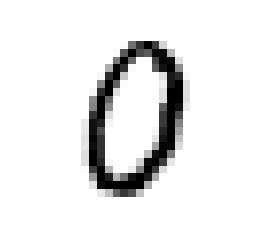

In [5]:
# save label info
labels = data.label 
labels_flat = data[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0] # number of classes

# display image
images = data.drop("label",axis=1)
images = images.astype(np.float)
images = np.multiply(images, 1.0 / 255.0) # convert from [0:255] => [0.0:1.0]
image_size = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

def display(img):
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# output image  
print(labels[5])
display(images.iloc[5])

4


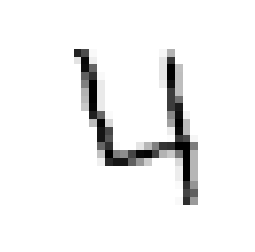

In [6]:
print(labels[3])
display(images.iloc[3])

For classification porpuses we convert the label to one-hot encoding (The neural net will ouput a vector of the same size with probabilities)

In [7]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print(labels.shape)
print ('labels[{0}] => {1}'.format(10,labels[10]))

(42000, 10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


Now we split the data into training a validation set

In [8]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print("Size of training set - Rows: {0}, Columns: {1}".format(train_images.shape[0],
                                                              train_images.shape[1]))
print("Size of validation set - Rows: {0}, Columns: {1}".format(validation_images.shape[0],
                                                                validation_images.shape[1]))

Size of training set - Rows: 40000, Columns: 784
Size of validation set - Rows: 2000, Columns: 784


## 3. Tensor Flow graph

In this secction we will build the tensor flow graph.

We will be using ReLu **c[f(x)=max(0,x)]** for our activation functions. When using ReLU it's good practice to initialize weights with a small amount of positive bias (on top of the small amount of noise) to avoid "dead neurons".

Next cell defines functions to initialize tensor flow variables weights and bias.

In [9]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape) #initialized to small value
    return tf.Variable(initial)

Next cell defines a funtion to create convolution layers.

We use 0 padded convolutions so output of the convolution is the same size of the input:

In [10]:
# convolution
def conv2d(x, W):
    #Computes a 2-D convolution given 4-D input and filter tensors.
    return tf.nn.conv2d(x, #input  A 4-D Tensor
                        W, # weights/filter
                        strides=[1, 1, 1, 1], 
                        padding='SAME') # 0 padding

For pooling (downsample) we use 2x2 max-pooling (Keeps the maximun of 2x2 blocks)

In [11]:
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, #input. A 4-D Tensor with shape [batch, height, width, channels] and type tf.float32.
                          ksize=[1, 2, 2, 1], #The size of the window for each dimension of the input tensor
                          strides=[1, 2, 2, 1],
                          padding='SAME')

Let's create placeholders for input an output of each layer:

In [12]:
# images
x = tf.placeholder(tf.float32, shape=[None, image_size]) 
# labels
y_ = tf.placeholder(tf.float32, shape=[None, labels_count])

Now that we have our functions defined we are going to build the neural net. To keep in simple we use 2 convolutional layers with a pooling layer in between.

The first layer computes 32 features (32 nodes) using 5X5 patches. Its weight tensor has a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels (1 means that images are grayscale), and the last is the number of output channels (nodes). There is also a bias vector with a component for each output channel.

To apply the layer, we reshape the input data to a 4d tensor, with the first dimension corresponding to the number of images, second and third - to image width and height, and the final dimension - to the number of colour channels.

After the convolution, pooling reduces the size of the output from 28x28 to 14x14.

In [13]:
# weights 1
W_conv1 = weight_variable([5, 5, 1, 32]) #x1,x2, input(greyscale), output
# bias 1
b_conv1 = bias_variable([32])
# input 1
image = tf.reshape(x, [-1, image_width, image_height, 1]) # input (40000,784) => output (40000,28,28,1)
# convolution 1 (+ relu)
h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1) # outputs (40000, 28, 28, 32)
# pooling 1
h_pool1 = max_pool_2x2(h_conv1) # outputs (40000, 14, 14, 32)

The second layer has 64 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 32, 64]. The first two dimensions are the patch size, the next is the number of input channels (32 channels correspond to 32 featured that we got from previous convolutional layer), and the last is the number of output channels. There is also a bias vector with a component for each output channel.

Because the image is down-sampled by pooling to 14x14 size, the second convolutional layer picks up more general characteristics of the images. Filters cover more space of the picture. Therefore, it is adjusted for more generic features while the first layer finds smaller details.

In [14]:
# weights 2
W_conv2 = weight_variable([5, 5, 32, 64]) #x1,x2, input(greyscale) of previous layer neurons, output
# bias 2
b_conv2 = bias_variable([64])
# convolution 2
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # outputs (40000, 14,14, 64)
# pooling 2
h_pool2 = max_pool_2x2(h_conv2) #  outputs (40000, 7, 7, 64)

Now that the image size is reduced to 7x7, we add a fully-connected layer with 1024 neurones to allow processing on the entire image (each of the neurons of the fully connected layer is connected to all the activations/outpus of the previous layer)

In [15]:
# weights fc
W_fc1 = weight_variable([7 * 7 * 64, 1024]) # [all pixels input, neurons]
# bias fc
b_fc1 = bias_variable([1024])
# input
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64]) # (40000, 7, 7, 64) => (40000, 3136)
# fully connecter layer
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1) # outpus (40000, 1024)

To prevent overfitting, we apply a dropout layer before the readout layer.

Dropout removes some nodes from the network at each training stage. Each of the nodes is either kept in the network with probability `keep_prob` or dropped with probability (1 - `keep_prob`).

After the training stage is over the nodes are returned to the NN with their original weights.

In [16]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Finally, we add a softmax layer (readout) that outputs probabilities. See how weights are added to the output of the dropout layer.

In [17]:
# weights
W_fc2 = weight_variable([1024, labels_count]) # for dropout layer
# bias
b_fc2 = bias_variable([labels_count]) #for droupout layer
# softmax
y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2) # outputs (40000, 10)

In [18]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

To evaluate network performance we use cross-entropy and to minimise this loss function we use ADAM optimiser.

ADAM optimiser is a gradient based optimization algorithm, based on adaptive estimates, it's more sophisticated than steepest gradient descent and is well suited for problems with large data or many parameters.

For evaluation of the model we use accuracy.

To predict values from test data, highest probability is picked from "one-hot vector" indicating that chances of an image being one of the digits are highest.

In [19]:
# prediction function
predict = tf.argmax(y,1)

We also want to be able to visualize output of the hidden layers to see what features are being discovered. 

In [20]:
### Prepare for visualization hidden layer 1
# display output of hidden layer 1: 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  
# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4, 2))
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

### Prepare for visualization hidden layer 2
# display output of hidden layer 2: 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  
# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))
layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

Our neural network structure is now defined and TensorFlow graph is ready for training.

## 4. Training and validation

Beause there is a lot of data (40000 observations in training data) we generate batches that will be fed the the model. The following function provides the batches.

In [21]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
        
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

Now, we have everything defined so we can start the tensor flow session. This way tensorflow will take care of all operations.

In [22]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Each step we get a "batch" of data points from the training set and feed it to the graph to replace the placeholders. In this case, it's: x, y and dropout.

Also, every certain number of epochs we check training accuracy on an upcoming "batch".

In [23]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):
    
    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        
    
    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('train_accuracy / val_accuracy => %.2f / %.2f for step %d'%(train_accuracy,
                                                                              validation_accuracy,
                                                                              i))
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
                
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

train_accuracy / val_accuracy => 0.12 / 0.16 for step 0
train_accuracy / val_accuracy => 0.16 / 0.16 for step 1
train_accuracy / val_accuracy => 0.08 / 0.16 for step 2
train_accuracy / val_accuracy => 0.04 / 0.24 for step 3
train_accuracy / val_accuracy => 0.16 / 0.36 for step 4
train_accuracy / val_accuracy => 0.16 / 0.28 for step 5
train_accuracy / val_accuracy => 0.08 / 0.28 for step 6
train_accuracy / val_accuracy => 0.08 / 0.24 for step 7
train_accuracy / val_accuracy => 0.20 / 0.24 for step 8
train_accuracy / val_accuracy => 0.32 / 0.12 for step 9
train_accuracy / val_accuracy => 0.08 / 0.08 for step 10
train_accuracy / val_accuracy => 0.32 / 0.48 for step 20
train_accuracy / val_accuracy => 0.28 / 0.60 for step 30
train_accuracy / val_accuracy => 0.52 / 0.68 for step 40
train_accuracy / val_accuracy => 0.52 / 0.68 for step 50
train_accuracy / val_accuracy => 0.52 / 0.80 for step 60
train_accuracy / val_accuracy => 0.80 / 0.80 for step 70
train_accuracy / val_accuracy => 0.92 / 0

We ended up with 100% accuracy on both the training set and the validation "batch". Let's see the score on the validation set and visualize the progress during the training phase.

validation_accuracy => 0.9635


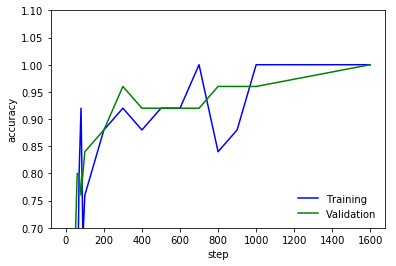

In [24]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

The plot shows how training a validation scores settle together towards the end which is a sign that we are not overfitting.

## 5. Predict

Now, we could use the CNN to predict unseen images.

In [25]:
# read test data from CSV file 
test_images = pd.read_csv('./data/test.csv').values
test_images = test_images.astype(np.float)

# convert 
test_images = np.multiply(test_images, 1.0 / 255.0) #[0:255] => [0.0:1.0]
print('test_images({0[0]},{0[1]})'.format(test_images.shape))

# predict test set
# using batches is more resource efficient
predicted_labels = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_labels[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE],
                                                                    keep_prob: 1.0})

print('predicted_lables({0})'.format(len(predicted_labels)))

test_images(28000,784)
predicted_lables(28000)


## 6. Visualize hidden layers

As it was mentioned before, it is good to output some variables for a better understanding of the process.
Here we pull an output of the first convolution layer from TensorFlow graph. 32 features are transformed into an image grid, and it's quite interesting to see how filters picked by NN outline characteristics of different digits.

predicted_lables[6] => 7.0


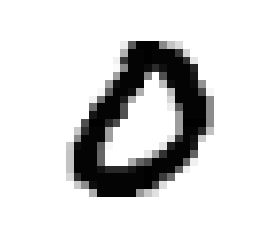

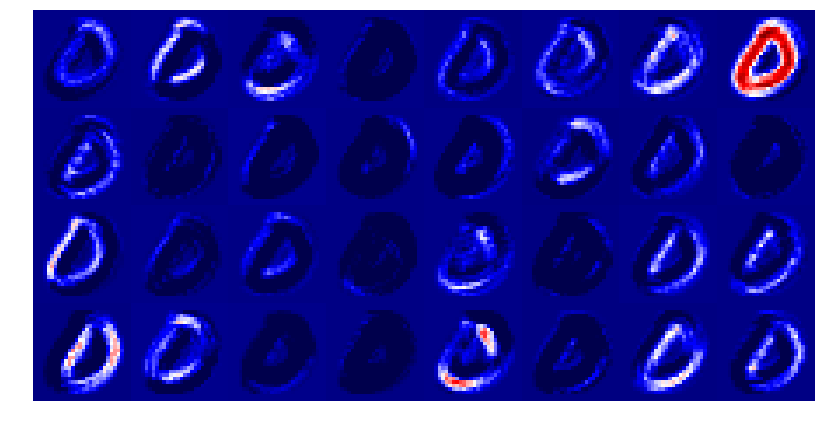

In [26]:
IMAGE_TO_DISPLAY = 6
# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_labels[5]))
layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.figure(figsize=(14, 14))
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )
plt.show()

We can also visualize the output of the second hidden layer for the same observation.

predicted_lables[6] => 0.0


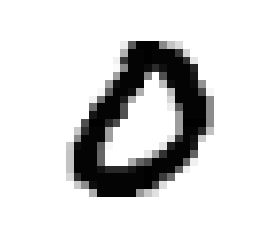

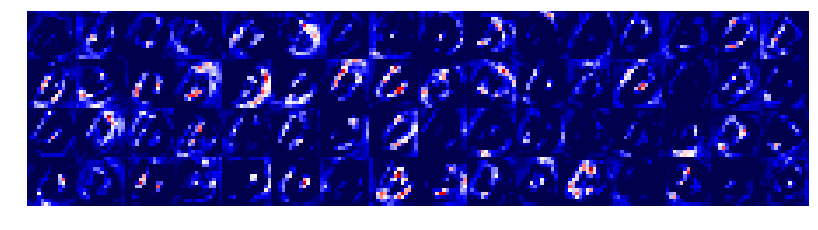

In [27]:
IMAGE_TO_DISPLAY = 6
# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_labels[IMAGE_TO_DISPLAY]))
layer2_grid = layer2.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.figure(figsize=(14, 14))
plt.axis('off')
plt.imshow(layer2_grid[0], cmap=cm.seismic )
plt.show()

Here is another example.

predicted_lables[45] => 7.0


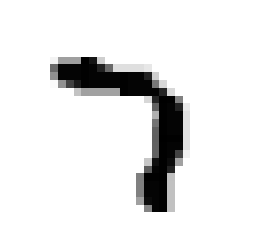

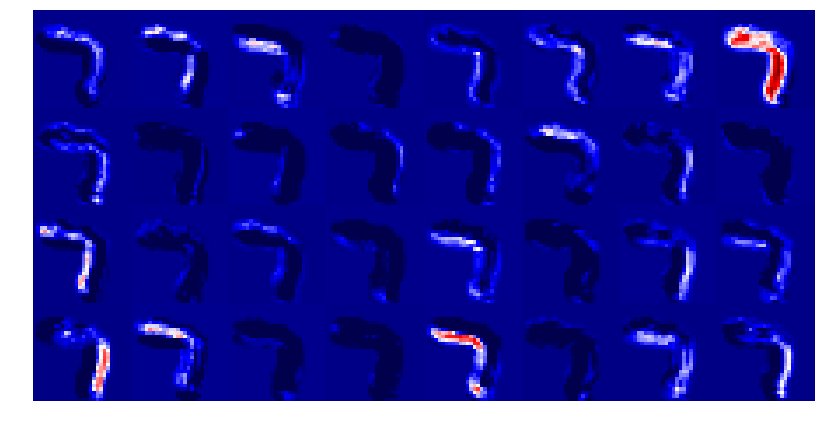

In [28]:
IMAGE_TO_DISPLAY = 45
# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_labels[IMAGE_TO_DISPLAY]))
layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.figure(figsize=(14, 14))
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )
plt.show()

predicted_lables[45] => 7.0


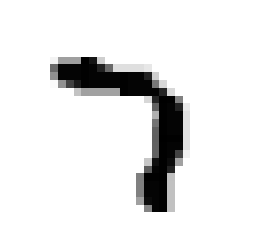

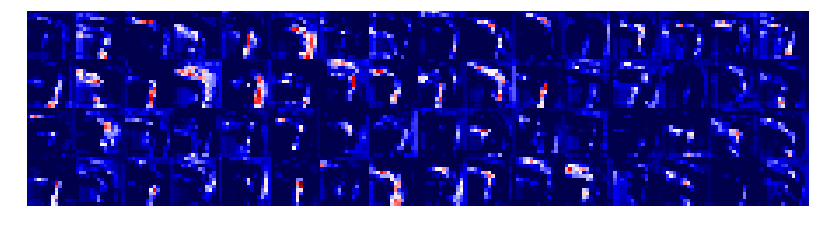

In [29]:
IMAGE_TO_DISPLAY = 45
# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_labels[IMAGE_TO_DISPLAY]))
layer2_grid = layer2.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.figure(figsize=(14, 14))
plt.axis('off')
plt.imshow(layer2_grid[0], cmap=cm.seismic )
plt.show()

Because the image is down-sampled by pooling to 14x14 size, the second convolutional layer picks up more general characteristics of the images. Filters cover more space of the picture. Therefore, it is adjusted for more generic features while the first layer finds smaller details.

In [30]:
sess.close()